### Getting Set Up: Load in Sheets, Set Indices, Drop Covariance

In [4]:
!pip install -r requirements_2.txt
#!pip install matplotlib

In [5]:
# just setting up functions to do demand stuff with 

import numpy as np
import pandas as pd
from cfe.estimation import drop_columns_wo_covariance
from cfe import Regression
!pip install fooddatacentral

In [6]:
hh_urban = pd.read_csv('HH_Urban.csv')
hh_rural = pd.read_csv('HH_Rural.csv')
exp_urban = pd.read_csv('Expenditures_Urban.csv')
exp_rural = pd.read_csv('Expenditures_Rural.csv')

In [7]:
# format urban expenditures and household characteristics
exp_urban.set_index(['i', 't', 'm'], inplace=True)
exp_urban.columns.name = 'j'

hh_urban.set_index(['i','t','m'],inplace=True)
hh_urban.columns.name = 'k'

In [8]:
# format rural expenditures and household characteristics
exp_rural.set_index(['i', 't', 'm'], inplace=True)
exp_rural.columns.name = 'j'

hh_rural.set_index(['i','t','m'],inplace=True)
hh_rural.columns.name = 'k'

In [9]:
# get log values for expenditures 

y_rural = np.log(exp_rural)
y_urban = np.log(exp_urban)


/srv/conda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/srv/conda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [10]:
d_rural = hh_rural
d_urban = hh_urban 

In [11]:
# import the no covariance column function, and apply to log expenditures
import cfe
from cfe.estimation import drop_columns_wo_covariance

y_rural = drop_columns_wo_covariance(y_rural,min_obs=17)
y_urban = drop_columns_wo_covariance(y_urban,min_obs=17)

# not really sure what this is doing, ask ChatGPT
use_rural = y_rural.index.intersection(d_rural.index)
use_urban = y_urban.index.intersection(d_urban.index)

# set them to specific indices per rural 
y_rural = y_rural.loc[use_rural,:]
y_urban = y_urban.loc[use_urban,:]

# set them to specific indices per rural 
d_rural = d_rural.loc[use_rural,:]
d_urban = d_urban.loc[use_urban,:]

### Now Actually Estimate Demand System

In [12]:
# this is a function that will return the initial expenditure 
# demand graph, for all goods and quantities (?)

def expenditure_demand(y, d): 
    # stack dataframes
    y = y.stack()
    d = d.stack()
    # remove duplicate indices
    idx = np.unique(d.index.values, return_index = True)[1]
    d = d.iloc[idx]
    result = cfe.Regression(y=y,d=d,min_obs=17,min_prop_items=0,alltm=False)
    df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
    return result, df

In [13]:
result, df = expenditure_demand(y_rural, d_rural)

In [15]:
df

y  yhat
i    t    m             j                             
474  2000 Metropolitana Avocado         0.583198   NaN
                        Beef            1.619360   NaN
                        Beef Entrails        NaN   NaN
                        Bread (french)  1.224128   NaN
                        Bread (sweet)   1.224128   NaN
...                                          ...   ...
7276 2000 Suroriente    Pork                 NaN   NaN
                        Rice            0.326634   NaN
                        Salt            0.732099   NaN
                        Soup                -inf   NaN
                        Tomatoes        0.475885   NaN

[79447 rows x 2 columns]

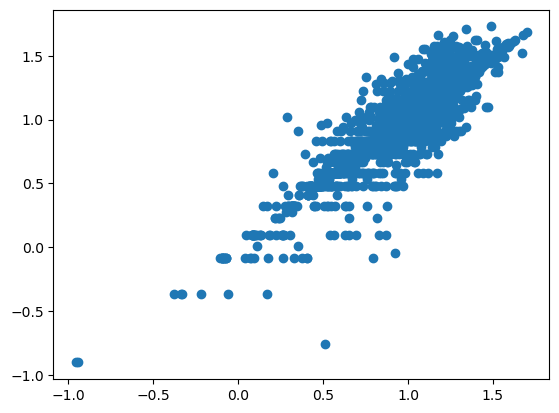

In [14]:
# and plotting it: 
import matplotlib.pyplot as plt
#%matplotlib notebook

plt.scatter(df['yhat'], df['y'])

In [16]:
result.graph_beta?

Signature:
result.graph_beta(
    fn=None,
    xlabel='Frisch Elasticities',
    heteroskedastic=False,
)
Docstring: <no docstring>
File:      /srv/conda/lib/python3.9/site-packages/cfe/regression.py
Type:      method

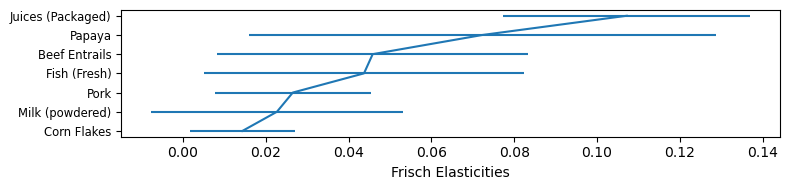

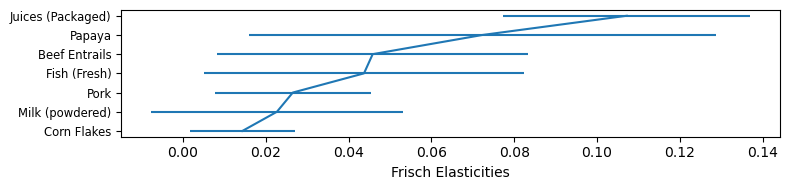

In [18]:
# can grab the coefficient values, which represent a quasi-income demand elasticity 
coefficients = result.get_beta().sort_values()

# can also plot this: 
result.graph_beta()


### Note for Reviewer: 
As you can see we are not getting coefficients or demand results for many foods (there are 96 in the original spreadsheet.) Am currently thinking this is either because those had NaN values, or because those foods were dropped with the covariance operation, but it seems like a lot, and trying to figure out how to still plot those as well. 

In [20]:
coefficients

j
Corn Flakes          0.014343
Milk (powdered)      0.022692
Pork                 0.026527
Fish (Fresh)         0.043717
Beef Entrails        0.045813
Papaya               0.072339
Juices (Packaged)    0.107173
Name: beta, dtype: float64

#### Estimating Demand for Individual Goods and Household Compositions

In [21]:
# check out: 
result.gamma



k,Unnamed: 0,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,...,Males 51-99,Females 51-99,log HSize,Rural,total,under_4,frac_under_4,under_9,frac_under_9,Constant
j,,,,,,,,,,,,,,,,,,,,,
Avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bananas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef Entrails,9.184620e-07,0.056871,-0.008321,-0.048062,-0.02038,-0.014546,-0.008689,-0.020556,0.004949,0.031476,...,0.005217,0.030323,0.197923,-1.110223e-16,-0.008577,0.04855,-0.356744,-0.019891,0.091297,0.85336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomato Sauce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tomatoes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Watermelon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
result.predicted_expenditures()

i     t     m              j                
474   2000  Metropolitana  Beef Entrails       NaN
                           Corn Flakes         NaN
                           Fish (Fresh)        NaN
                           Juices (Packaged)   NaN
                           Milk (powdered)     NaN
                                                ..
7276  2000  Suroriente     Fish (Fresh)        NaN
                           Juices (Packaged)   NaN
                           Milk (powdered)     NaN
                           Papaya              NaN
                           Pork                NaN
Length: 20069, dtype: float64

In [49]:
food = 'Papaya'
xhat = result.predicted_expenditures() # grab household vector 
p = np.exp(result.get_Ar()) # relative prices deduced in model
scale = np.linspace(0.5, 2, 20) # y axis scale
    
xbar = xhat.groupby(['i','t','m']).sum() # Total food expenditures per household
pbar = p.xs(key='Central',level='m').groupby('j').mean()
pbar = pbar[food]

In [52]:
pbar

0.9894529025220105

In [55]:
p

t     m              j                
2000  Central        Beef Entrails        1.005946
                     Corn Flakes          0.979954
                     Fish (Fresh)         0.989013
                     Juices (Packaged)    1.002423
                     Milk (powdered)      1.000249
                     Papaya               0.989453
                     Pork                 1.019746
      Metropolitana  Beef Entrails        1.059376
                     Corn Flakes          0.957078
                     Fish (Fresh)         1.073237
                     Juices (Packaged)    0.979448
                     Milk (powdered)      1.013991
                     Papaya               0.991343
                     Pork                 0.953935
      Noroccidente   Beef Entrails        0.969113
                     Corn Flakes          1.033629
                     Fish (Fresh)         0.895794
                     Juices (Packaged)    0.994226
                     Milk (powdered)      0

In [83]:
pbar

0.9894529025220105

In [101]:
def specific_demand(result, food=''): 
    xhat = result.predicted_expenditures() # grab household vector 
    p = np.exp(result.get_Ar()) # relative prices deduced in model
    scale = np.linspace(0.5, 2, 23) # y axis scale
    
    xbar = xhat.groupby(['i','t','m']).sum() # Total food expenditures per household
    pbar = p.xs(key='2000', level='t').groupby('j').mean()

    def my_prices(p0, p=pbar, food=''):
        p = p.copy()
        p.loc[food] = p0
        return p

    for s in scale: 
        plt.plot(result.demands(xbar.quantile(0.25), my_prices(pbar * s, pbar, food=food), scale))

In [102]:
specific_demand(result, food = 'Papaya')

KeyError: '2000'

In [103]:
r = result
xhat = r.predicted_expenditures()
# Implied relative prices
p = np.exp(r.get_Ar())

In [104]:
p

t     m              j                
2000  Central        Beef Entrails        1.005946
                     Corn Flakes          0.979954
                     Fish (Fresh)         0.989013
                     Juices (Packaged)    1.002423
                     Milk (powdered)      1.000249
                     Papaya               0.989453
                     Pork                 1.019746
      Metropolitana  Beef Entrails        1.059376
                     Corn Flakes          0.957078
                     Fish (Fresh)         1.073237
                     Juices (Packaged)    0.979448
                     Milk (powdered)      1.013991
                     Papaya               0.991343
                     Pork                 0.953935
      Noroccidente   Beef Entrails        0.969113
                     Corn Flakes          1.033629
                     Fish (Fresh)         0.895794
                     Juices (Packaged)    0.994226
                     Milk (powdered)      0

In [27]:
p.xs?

Signature:
p.xs(
    key: 'IndexLabel',
    axis: 'Axis' = 0,
    level: 'IndexLabel | None' = None,
    drop_level: 'bool_t' = True,
) -> 'Self'
Docstring:
Return cross-section from the Series/DataFrame.

This method takes a `key` argument to select data at a particular
level of a MultiIndex.

Parameters
----------
key : label or tuple of label
    Label contained in the index, or partially in a MultiIndex.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Axis to retrieve cross-section on.
level : object, defaults to first n levels (n=1 or len(key))
    In case of a key partially contained in a MultiIndex, indicate
    which levels are used. Levels can be referred by label or position.
drop_level : bool, default True
    If False, returns object with same levels as self.

Returns
-------
Series or DataFrame
    Cross-section from the original Series or DataFrame
    corresponding to the selected index levels.

See Also
--------
DataFrame.loc : Access a group of rows and columns
  

IndexError: invalid index to scalar variable.

In [25]:
pd.DataFrame.stack?

Signature: pd.DataFrame.stack(self, level: 'Level' = -1, dropna: 'bool' = True)
Docstring:
Stack the prescribed level(s) from columns to index.

Return a reshaped DataFrame or Series having a multi-level
index with one or more new inner-most levels compared to the current
DataFrame. The new inner-most levels are created by pivoting the
columns of the current dataframe:

  - if the columns have a single level, the output is a Series;
  - if the columns have multiple levels, the new index
    level(s) is (are) taken from the prescribed level(s) and
    the output is a DataFrame.

Parameters
----------
level : int, str, list, default -1
    Level(s) to stack from the column axis onto the index
    axis, defined as one index or label, or a list of indices
    or labels.
dropna : bool, default True
    Whether to drop rows in the resulting Frame/Series with
    missing values. Stacking a column level onto the index
    axis can create combinations of index and column values
    that are mis